<a href="https://colab.research.google.com/github/antoniovfonseca/summarize-change-components/blob/main/summarize_change_components_google_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1.Environment Setup**


---



### **1.1.Install Python Libraries**


In [1]:
%pip -q install \
    rasterio \
    seaborn \
    xlsxwriter \
    matplotlib-scalebar \
    matplotlib-map-utils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 31.5 MB/s eta 0:00:00


### **1.2.Importing Libraries**

In [11]:
# Standard library
import glob
import os
import pickle
import sys
import time

# Typing for annotations
from typing import Dict, List, Optional

# Third-party
import numba as nb
import numpy as np
import pandas as pd
import rasterio
import xlsxwriter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from numba import prange
from pyproj import Transformer
from pyproj import Geod
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

# Rasterio submodules
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.enums import Resampling

# Matplotlib extensions
from matplotlib.ticker import FuncFormatter
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib_map_utils import north_arrow
from matplotlib.colors import (
    ListedColormap,
    BoundaryNorm,
    Normalize,
    LinearSegmentedColormap,
)
from matplotlib.patches import Patch, Rectangle, FancyArrowPatch

### **1.3.Mounting Google Drive in Colab**



In [12]:
# Run only if using Google Colab
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **2.Data Preparation**

### **2.1.Setting Paths to Image Files**

The user must include the year in the raster map name.

In [13]:
# List of input raster paths
image_paths = [
    "/content/drive/MyDrive/change-components/input/lulc_mapbiomas_1990.tif",
    "/content/drive/MyDrive/change-components/input/lulc_mapbiomas_1995.tif",
    "/content/drive/MyDrive/change-components/input/lulc_mapbiomas_2000.tif",
    "/content/drive/MyDrive/change-components/input/lulc_mapbiomas_2005.tif",
    "/content/drive/MyDrive/change-components/input/lulc_mapbiomas_2010.tif",
    "/content/drive/MyDrive/change-components/input/lulc_mapbiomas_2015.tif",
    "/content/drive/MyDrive/change-components/input/lulc_mapbiomas_2020.tif",
]

# Raster mask path
mask_path = "/content/drive/MyDrive/change-components/input/WesternBahiaMask.tif"

# Check if all files exist
all_files = image_paths + [mask_path]
missing_files = [f for f in all_files if not os.path.exists(f)]

if missing_files:
    print("Missing files:")
    for f in missing_files:
        print(" -", f)
else:
    print("All input files found.")

All input files found.


### **2.2.Setting Path to Output Files**

In [14]:
# Output directory path
output_path = "/content/drive/MyDrive/change-components/output_colab"

# Create folder if it does not exist
if not os.path.exists(output_path):
    os.makedirs(output_path)
    print("Folder created:", output_path)
else:
    print("Folder already exists:", output_path)

Folder already exists: /content/drive/MyDrive/change-components/output_colab


### **2.3.Setting Years of the Time Intervals**

In [15]:
# Years of input rasters
years = [1990, 1995, 2000, 2005, 2010, 2015, 2020]

### **2.4.Setting the classes**

In [16]:
# Class ID, names, and colors
class_labels_dict = {
     0: {"name": "Background", "color": "#ffffff"},
     4: {"name": "Savanna",    "color": "#ff0000"},
    12: {"name": "Grassland",  "color": "#8b0000"},
     3: {"name": "Forest",     "color": "#ffffcc"},
    33: {"name": "Water",      "color": "#ffff99"},
    46: {"name": "Coffee",     "color": "#ffff66"},
    29: {"name": "Rocky",      "color": "#ffff00"},
    11: {"name": "Wetland",    "color": "#cc9900"},
    24: {"name": "Urban",      "color": "#ffcccc"},
     9: {"name": "Plantation", "color": "#ffcc99"},
    48: {"name": "Perennial",  "color": "#ffcc66"},
    25: {"name": "Barren",     "color": "#ffcc00"},
    21: {"name": "Mosaic",     "color": "#ff9900"},
    62: {"name": "Cotton",     "color": "#ff66ff"},
    15: {"name": "Pasture",    "color": "#cc00cc"},
    41: {"name": "Temporary",  "color": "#0000ff"},
    39: {"name": "Soybean",    "color": "#00bfff"},
}

# Sorted list of renamed class labels
class_labels = [class_labels_dict[key]["name"] for key in sorted(class_labels_dict.keys())]

### **2.4.Apply Mask**
The function applies a binary mask to the input rasters, keeping only the pixels where the mask value equals 1 and setting the others to 0. It then converts the data to 8-bit format and saves the results as LZW-compressed TIFF files.

In [9]:
def apply_mask_to_images(image_paths, output_path, mask_path=None):
    """
    Apply a mask to raster images and save as 8-bit TIFFs.

    Args:
        image_paths (list[str]): Paths to input images.
        output_path (str): Directory to save masked images.
        mask_path (str, optional): Path to mask raster.

    Returns:
        list[str]: Paths to saved masked images.
    """
    # Create output folder if missing
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    saved_paths = []

    # Load mask if provided
    mask_data = None
    if mask_path:
        with rasterio.open(mask_path) as mask_file:
            mask_data = mask_file.read(1)

    # Apply mask to each image
    for path in image_paths:
        with rasterio.open(path) as image:
            meta = image.meta.copy()

            # Force 8-bit TIFF settings
            meta["dtype"] = "uint8"
            meta["nodata"] = 0
            meta["driver"] = "GTiff"
            meta["compress"] = "lzw"

            # Read raster band and apply mask
            image_data = image.read(1)
            if mask_data is not None:
                masked_data = (image_data * (mask_data == 1)).astype("uint8")
            else:
                masked_data = image_data.astype("uint8")

            # Build output path
            base_name = os.path.basename(path).replace(".tif", "_masked.tif")
            masked_path = os.path.join(output_path, base_name)

            # Save masked image
            with rasterio.open(masked_path, "w", **meta) as dest:
                dest.write(masked_data, 1)

            saved_paths.append(masked_path)

    return saved_paths


# Apply mask and save results
masked_image_paths = apply_mask_to_images(image_paths, output_path, mask_path)

# Print saved paths
for path in masked_image_paths:
    print(path)

/content/drive/MyDrive/change-components/output_colab/lulc_mapbiomas_1990_masked.tif
/content/drive/MyDrive/change-components/output_colab/lulc_mapbiomas_1995_masked.tif
/content/drive/MyDrive/change-components/output_colab/lulc_mapbiomas_2000_masked.tif
/content/drive/MyDrive/change-components/output_colab/lulc_mapbiomas_2005_masked.tif
/content/drive/MyDrive/change-components/output_colab/lulc_mapbiomas_2010_masked.tif
/content/drive/MyDrive/change-components/output_colab/lulc_mapbiomas_2015_masked.tif
/content/drive/MyDrive/change-components/output_colab/lulc_mapbiomas_2020_masked.tif


### **2.5.Display the Maps**

The code defines a function to find files with a given suffix and returns their paths. It then defines a function that plots each raster file with a specified color map, and a legend. It reads the raster data with rasterio, reshapes it, applies the color map, and arranges the images in a single row of subplots. It sets each plot’s title with the provided year, hides the axes, and includes a custom legend. Finally, it saves the plot as a JPEG and displays it.

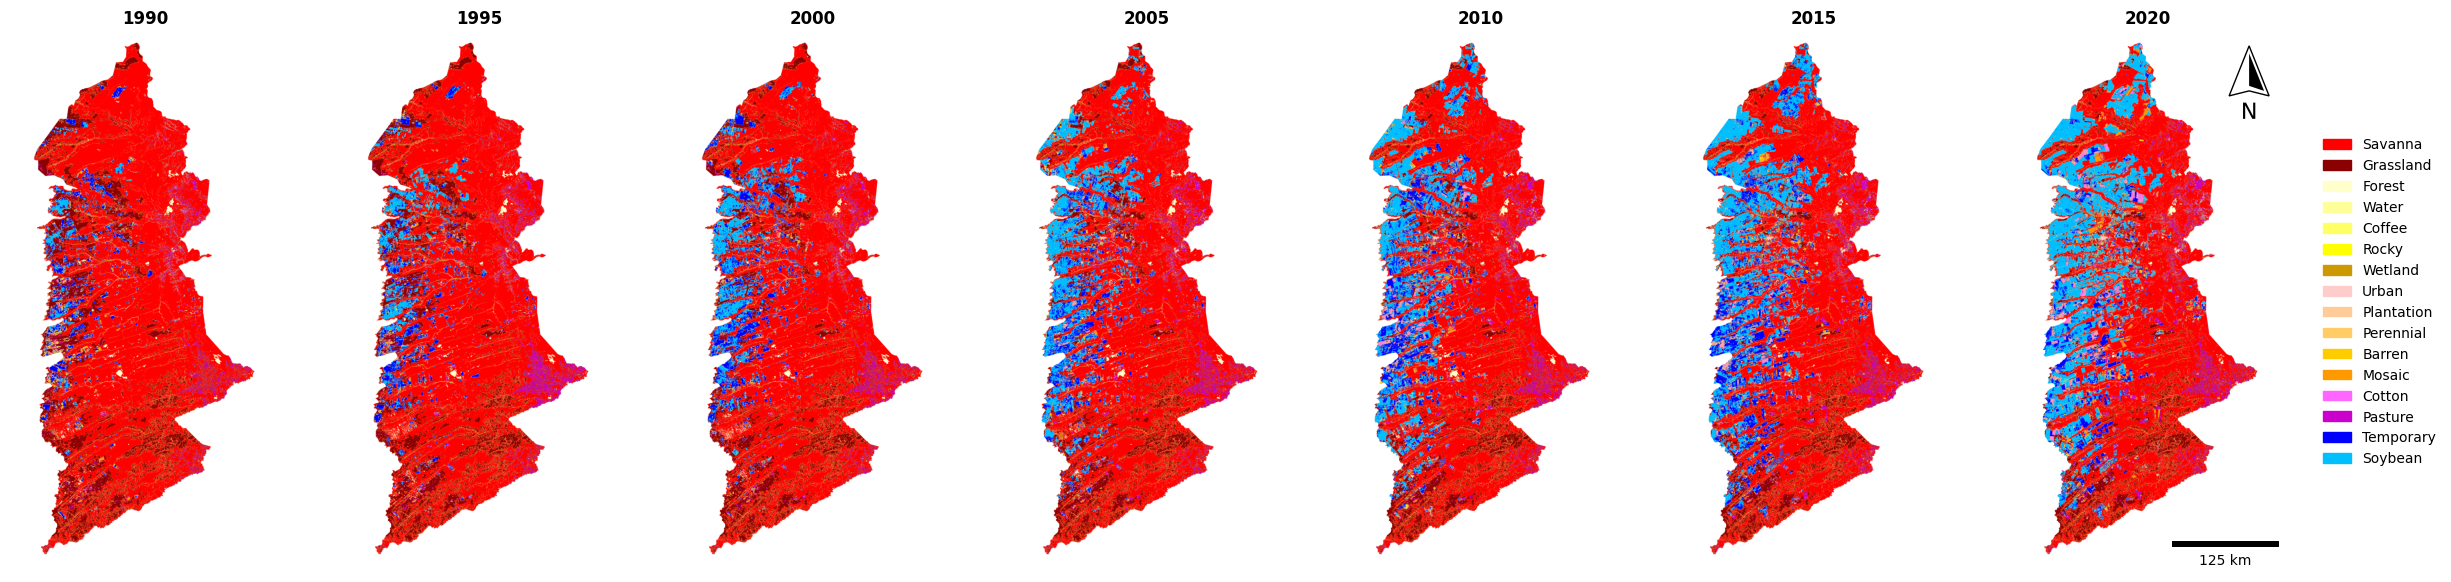

In [19]:
def _dx_km_generic_for_display(
    raster_path: str,
    downsample_divisor: int,
) -> float:
    """Return km per displayed pixel for any CRS (geodesic at mid-lat)."""
    with rasterio.open(raster_path) as src:
        left, bottom, right, top = src.bounds
        lat_mid_src = (top + bottom) / 2.0

        to_ll = Transformer.from_crs(
            src.crs,
            "EPSG:4326",
            always_xy=True,
        )
        lon_l, lat_mid = to_ll.transform(
            left,
            lat_mid_src,
        )
        lon_r, _ = to_ll.transform(
            right,
            lat_mid_src,
        )

        geod = Geod(ellps="WGS84")
        _, _, width_m = geod.inv(
            lon_l,
            lat_mid,
            lon_r,
            lat_mid,
        )

        cols_disp = max(
            1,
            src.width // downsample_divisor,
        )
        return (width_m / cols_disp) / 1_000  # km/pixel


def plot_classified_images(
    # image_paths: List[str],
    class_map: Dict[int, Dict[str, str]],
    years: List[int],
    output_path: str,
    downsample_divisor: int = 4,             # display downsample
    panel_size: tuple = (4.0, 6.0),          # width, height per panel (inches)
    dx_km: Optional[float] = None,           # km/pixel (auto if None)
    resampling_method: Resampling = Resampling.bilinear,
) -> None:

    image_paths = sorted(glob.glob(os.path.join(output_path, "*masked.tif")))

    """Plot classified rasters with legend, north arrow, and km scale bar."""
    if not image_paths:
        raise ValueError("image_paths is empty.")
    if len(image_paths) != len(years):
        raise ValueError("image_paths and years must match in length.")

    # Figure
    n_images = len(image_paths)
    fig, axs = plt.subplots(
        1,
        n_images,
        figsize=(panel_size[0] * n_images, panel_size[1]),
        sharey=True,
        constrained_layout=False,
    )
    plt.subplots_adjust(
        left=0.02,
        right=0.85,
        top=0.95,
        bottom=0.05,
        wspace=0.04,
    )

    # Colormap and norm
    class_ids_sorted = sorted(class_map.keys())
    cmap = ListedColormap(
        [class_map[k]["color"] for k in class_ids_sorted]
    )
    norm = BoundaryNorm(
        class_ids_sorted + [class_ids_sorted[-1] + 1],
        cmap.N,
    )

    # Km per displayed pixel
    if dx_km is None:
        dx_km = _dx_km_generic_for_display(
            image_paths[0],
            downsample_divisor,
        )

    # Plot rasters
    axes = axs if n_images > 1 else [axs]
    for i, (path, ax) in enumerate(zip(image_paths, axes)):
        with rasterio.open(path) as src:
            h = max(1, src.height // downsample_divisor)
            w = max(1, src.width // downsample_divisor)
            data = src.read(
                1,
                out_shape=(h, w),
                resampling=resampling_method,
            )
        ax.imshow(
            data,
            cmap=cmap,
            norm=norm,
        )
        ax.set_title(
            f"{years[i]}",
            fontweight="bold",
        )
        ax.axis("off")

    # Legend (exclude id 0)
    legend_ids = [k for k in class_map.keys() if k != 0]
    legend_elements = [
        Rectangle(
            (0, 0),
            1,
            1,
            color=class_map[k]["color"],
            label=class_map[k]["name"],
        )
        for k in legend_ids
    ]
    fig.legend(
        handles=legend_elements,
        loc="center right",
        bbox_to_anchor=(0.9, 0.5),
        frameon=False,
    )

    # Scale bar (km)
    scalebar = ScaleBar(
        dx=dx_km,
        units="km",
        length_fraction=0.4,
        location="lower right",
        scale_loc="bottom",
        color="black",
        box_alpha=0,
    )
    axes[-1].add_artist(
        scalebar
    )

    # North arrow
    north_arrow(
        axes[-1],
        location="upper right",
        shadow=False,
        rotation={"degrees": 0},
    )

    # Save
    out_fig = os.path.join(
        output_path,
        "plot_input_maps.jpeg",
    )
    plt.savefig(
        out_fig,
        format="jpeg",
        bbox_inches="tight",
        dpi=300,
    )
    plt.show()
    plt.close()


# Call
plot_classified_images(
    # masked_image_paths,
    class_labels_dict,
    years,
    output_path,
)


## **3.Generate the Transition Matrix**


---
In this section, the computer code will generate four different transition matrices. The first one is related to each time interval. The second one is the transition matrix for the temporal extent, which is represented for the first and last time point of the time extent. The third one is a transition matrix that represents the sum of all time intervals. And the last transition matrix is the alternation matrix, which is the sum matrix minus the extent matrix.

Before generate the transition matrix, the computer code will analyze the presence of 0, NULL and NA value in all maps. If there is a presence of one of these values, the computer code will create a mask with these values and will remove all the pixels in the same position in all maps and years.

All the transition matrix will be salved in the Google Drive in the ".csv" format.

In [12]:
# Generate the Transition Matrix
def generate_mask_and_flatten_rasters(
    output_path: str,
    suffix: str = "_masked.tif",
) -> List[np.ndarray]:
    """
    Read rasters by suffix, mask zeros/NaN/nodata, and flatten valid values.

    Args:
        output_path: Folder containing rasters.
        suffix: Filename suffix to select rasters.

    Returns:
        List of flattened arrays (one per raster).
    """
    # Collect and sort raster paths
    image_paths = [
        os.path.join(output_path, f)
        for f in os.listdir(output_path)
        if f.endswith(suffix)
    ]
    image_paths.sort()

    all_data: List[np.ndarray] = []
    all_masks: List[np.ndarray] = []

    # Read and mask rasters
    for path in image_paths:
        with rasterio.open(path) as src:
            data = src.read(1)
            mask = (data == 0) | (data == src.nodata) | np.isnan(data)
            all_masks.append(mask)
            all_data.append(data)

    # Union of masks
    combined_mask = np.any(all_masks, axis=0)

    # Flatten non-masked values
    flattened = [
        data[~combined_mask].flatten() if np.any(combined_mask) else data.flatten()
        for data in all_data
    ]
    return flattened


# Alias for readability
transition_matrix = confusion_matrix


def generate_all_matrices(
    output_path: str,
    suffix: str = "_masked.tif",
) -> tuple[list[int], np.ndarray]:
    """Generate interval, extent, sum, and alternation matrices and save CSVs."""
    global years  # uses the global list of years

    # Load processed data
    flattened_data = generate_mask_and_flatten_rasters(output_path, suffix)

    # Validate year count
    if len(years) != len(flattened_data):
        raise ValueError(
            f"Mismatch: {len(years)} years vs {len(flattened_data)} rasters"
        )

    # All classes present
    all_classes = np.unique(np.concatenate(flattened_data)).astype(int)

    # Interval matrices
    for i in range(len(flattened_data) - 1):
        cm = transition_matrix(
            flattened_data[i],
            flattened_data[i + 1],
            labels=all_classes,
        )
        out_csv = os.path.join(
            output_path,
            f"transition_matrix_{years[i]}-{years[i+1]}.csv",
        )
        pd.DataFrame(
            cm,
            index=all_classes,
            columns=all_classes,
        ).to_csv(out_csv)

    # Extent matrix
    extent_matrix = transition_matrix(
        flattened_data[0],
        flattened_data[-1],
        labels=all_classes,
    )
    out_csv = os.path.join(
        output_path,
        f"transition_matrix_extent_{years[0]}-{years[-1]}.csv",
    )
    pd.DataFrame(
        extent_matrix,
        index=all_classes,
        columns=all_classes,
    ).to_csv(out_csv)

    # Sum of interval matrices
    n = len(all_classes)
    sum_matrix = np.zeros((n, n), dtype=int)
    for i in range(len(flattened_data) - 1):
        sum_matrix += transition_matrix(
            flattened_data[i],
            flattened_data[i + 1],
            labels=all_classes,
        )
    out_csv = os.path.join(
        output_path,
        f"transition_matrix_sum_{years[0]}-{years[-1]}.csv",
    )
    pd.DataFrame(
        sum_matrix,
        index=all_classes,
        columns=all_classes,
    ).to_csv(out_csv)

    # Alternation matrix
    alternation_matrix = sum_matrix - extent_matrix
    out_csv = os.path.join(
        output_path,
        f"transition_matrix_alternation_{years[0]}-{years[-1]}.csv",
    )
    pd.DataFrame(
        alternation_matrix,
        index=all_classes,
        columns=all_classes,
    ).to_csv(out_csv)

    return years, all_classes


def main(output_path: str) -> None:
    """Matrix generation workflow."""
    # Ensure output folder exists
    os.makedirs(output_path, exist_ok=True)

    # Build all matrices
    print("Generating transition matrices...")
    years_out, all_classes = generate_all_matrices(output_path)

    print(f"Detected classes: {all_classes}")
    print("Matrices saved in:", output_path)


if __name__ == "__main__":
    main(output_path)

Generating transition matrices...
Detected classes: [ 3  4  9 11 12 15 21 24 25 29 33 39 41 46 48 62]
Matrices saved in: /content/drive/MyDrive/change-components/output_colab


## **4.Components of Change**


---
The code calculates components of change from transition matrices generated in the previous step. It features a ComponentCalculator class that processes matrices to determine the gain and loss of Quantity, Exchange, and Shift. The process_matrix function handles matrices for defined time intervals and the main function systematically processes these matrices for each time interval, aggregates the results, and exports the outcomes to a CSV file.

In [19]:
# Components from a transition matrix
class ComponentCalculator:
    """Compute Quantity, Exchange, and Shift per class."""

    def __init__(self, transition_matrix: np.ndarray) -> None:
        # Keep integer counts
        self.matrix = transition_matrix.astype(int)
        self.num_classes = transition_matrix.shape[0]
        self.class_components: list[dict] = []
        self.total_components = {
            "Quantity_Gain": 0,
            "Quantity_Loss": 0,
            "Exchange_Gain": 0,
            "Exchange_Loss": 0,
            "Shift_Gain": 0,
            "Shift_Loss": 0,
        }

    def calculate_components(self) -> "ComponentCalculator":
        """Fill per-class components (Quantity, Exchange, Shift)."""
        for class_idx in range(self.num_classes):
            gain_sum = np.sum(self.matrix[:, class_idx])
            loss_sum = np.sum(self.matrix[class_idx, :])

            q_gain = max(0, gain_sum - loss_sum)
            q_loss = max(0, loss_sum - gain_sum)

            mutual = np.sum(
                np.minimum(self.matrix[class_idx, :], self.matrix[:, class_idx])
            )
            exchange = mutual - self.matrix[class_idx, class_idx]

            total_trans = loss_sum - self.matrix[class_idx, class_idx]
            shift = max(0, total_trans - q_loss - exchange)

            self.class_components.append(
                {
                    "Quantity_Gain": q_gain,
                    "Quantity_Loss": q_loss,
                    "Exchange_Gain": exchange,
                    "Exchange_Loss": exchange,
                    "Shift_Gain": shift,
                    "Shift_Loss": shift,
                }
            )
        return self


def process_matrix(
    matrix_type: str,
    start_year: int | None = None,
    end_year: int | None = None,
) -> list[dict]:
    """Load a matrix CSV, compute components, and return tidy rows."""
    results: list[dict] = []
    fname: str | None = None

    try:
        # Resolve filename
        if matrix_type == "interval":
            fname = f"transition_matrix_{start_year}-{end_year}.csv"
        elif matrix_type == "extent":
            fname = f"transition_matrix_extent_{years[0]}-{years[-1]}.csv"
        elif matrix_type == "sum":
            fname = f"transition_matrix_sum_{years[0]}-{years[-1]}.csv"
        elif matrix_type == "alternation":
            fname = (
                f"transition_matrix_alternation_{years[0]}-{years[-1]}.csv"
            )

        # Validate path
        full_path = os.path.join(output_path, fname)
        if not os.path.exists(full_path):
            raise FileNotFoundError(f"File {full_path} does not exist")

        # Read matrix and compute components
        df = pd.read_csv(full_path, index_col=0)
        matrix_classes = [int(c) for c in df.index]
        calc = ComponentCalculator(df.values).calculate_components()

        # Build tidy records
        for idx, class_id in enumerate(matrix_classes):
            cls_name = class_labels_dict.get(class_id, {}).get(
                "name",
                f"Unknown_{class_id}",
            )
            comp = calc.class_components[idx]

            for component in ["Quantity", "Exchange", "Shift"]:
                component_name = component
                if matrix_type in ["extent", "sum"] and component in [
                    "Exchange",
                    "Shift",
                ]:
                    component_name = f"Allocation_{component}"

                results.append(
                    {
                        "Time_Interval": (
                            f"{start_year}-{end_year}"
                            if matrix_type == "interval"
                            else matrix_type
                        ),
                        "Class": cls_name,
                        "Component": component_name,
                        "Gain": comp[f"{component}_Gain"],
                        "Loss": comp[f"{component}_Loss"],
                    }
                )

    except Exception as e:
        print(f"ERROR in {matrix_type}: {str(e)}")
        return []

    return results


def main(output_path: str) -> None:
    """Main execution flow with simple logging."""
    all_results: list[dict] = []
    print("\n=== Starting processing ===")

    # 1) Interval matrices
    try:
        print("\nProcessing intervals...")
        for i in range(len(years) - 1):
            start = years[i]
            end = years[i + 1]
            print(f"  - {start}-{end}")
            all_results.extend(process_matrix("interval", start, end))
    except Exception as e:
        print(f"Fatal error in intervals: {str(e)}")
        return

    # 2) Extent matrix
    try:
        print("\nProcessing extent matrix...")
        all_results.extend(process_matrix("extent", None, None))
    except Exception as e:
        print(f"Fatal error in extent: {str(e)}")
        return

    # 3) Sum matrix
    try:
        print("\nProcessing sum matrix...")
        all_results.extend(process_matrix("sum", None, None))
    except Exception as e:
        print(f"Fatal error in sum: {str(e)}")
        return

    # 4) Alternation matrix
    try:
        print("\nAttempting alternation matrix...")
        alternation_path = os.path.join(
            output_path,
            f"transition_matrix_alternation_{years[0]}-{years[-1]}.csv",
        )

        if os.path.exists(alternation_path):
            df_alt = pd.read_csv(alternation_path, index_col=0)
            calc = ComponentCalculator(df_alt.values).calculate_components()

            for idx, class_id in enumerate(df_alt.index.astype(int)):
                cls_name = class_labels_dict.get(class_id, {}).get(
                    "name",
                    f"Unknown_{class_id}",
                )
                comp = calc.class_components[idx]

                all_results.extend(
                    [
                        {
                            "Time_Interval": "alternation",
                            "Class": cls_name,
                            "Component": "Alternation_Exchange",
                            "Gain": comp["Exchange_Gain"],
                            "Loss": comp["Exchange_Loss"],
                        },
                        {
                            "Time_Interval": "alternation",
                            "Class": cls_name,
                            "Component": "Alternation_Shift",
                            "Gain": comp["Shift_Gain"],
                            "Loss": comp["Shift_Loss"],
                        },
                    ]
                )
        else:
            print("Alternation matrix not found - skipping")
    except Exception as e:
        print(f"Non-fatal alternation error: {str(e)}")

    # 5) Export
    try:
        output_file = os.path.join(output_path, "change_components.csv")
        pd.DataFrame(all_results).to_csv(output_file, index=False)
        print(f"\n=== Success! Saved to: {output_file} ===")
        print(f"Total records: {len(all_results):,}")
    except Exception as e:
        print(f"\n!!! FATAL EXPORT ERROR: {str(e)} !!!")


if __name__ == "__main__":
    main(output_path)



=== Starting processing ===

Processing intervals...
  - 1990-1995
  - 1995-2000
  - 2000-2005
  - 2005-2010
  - 2010-2015
  - 2015-2020

Processing extent matrix...

Processing sum matrix...

Attempting alternation matrix...

=== Success! Saved to: /content/drive/MyDrive/change-components/output_colab/change_components.csv ===
Total records: 416


## **5.Graphics**

---



### **5.1 Setting the parameters for the graphics**

In [27]:
# Read change components CSV
csv_path = os.path.join(
    output_path,
    "change_components.csv",
)

# Validate path
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV not found: {csv_path}")

# Load into DataFrame
df = pd.read_csv(
    csv_path,
)

### **5.2 Change Components by Time Interval**


Component Totals by Time Interval (million pixels):

Time Interval: 1990-1995
Exchange: 5.37 M
Quantity: 3.75 M
Shift: 2.27 M

Time Interval: 1995-2000
Exchange: 7.07 M
Quantity: 3.86 M
Shift: 1.15 M

Time Interval: 2000-2005
Exchange: 7.47 M
Quantity: 5.28 M
Shift: 2.93 M

Time Interval: 2005-2010
Exchange: 9.86 M
Quantity: 4.74 M
Shift: 2.42 M

Time Interval: 2010-2015
Exchange: 11.75 M
Quantity: 5.07 M
Shift: 2.44 M

Time Interval: 2015-2020
Exchange: 9.02 M
Quantity: 7.24 M
Shift: 1.60 M


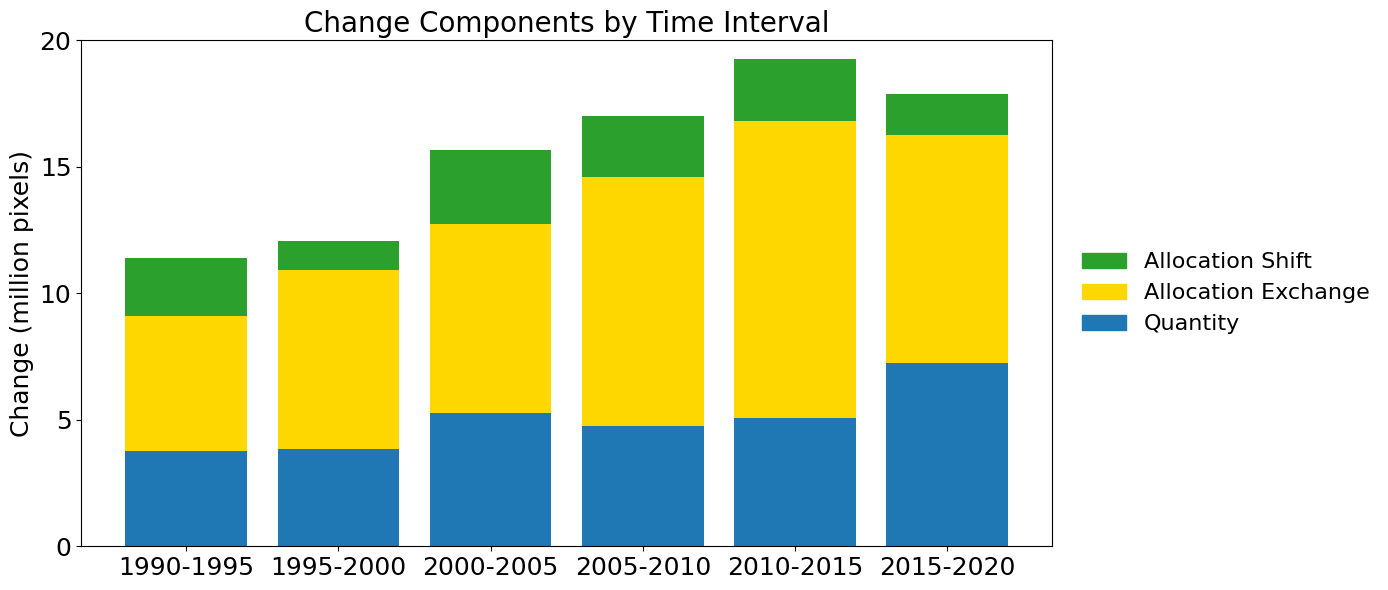

In [28]:
# Filter only time intervals
time_df = df[
    df["Time_Interval"].str.contains("-")
]

# Aggregate totals per interval and component (Gain)
totals = (
    time_df.groupby(
        ["Time_Interval", "Component"]
    )["Gain"]
    .sum()
    .unstack()
)

# Print totals in million pixels
print("\nComponent Totals by Time Interval (million pixels):")
for index, row in totals.iterrows():
    print(f"\nTime Interval: {index}")
    for component in row.index:
        print(f"{component}: {row[component] / 1e6:.2f} M")

# Create figure and axis
fig, ax = plt.subplots(
    figsize=(14, 6),
)

# Colors
colors = [
    "#1f77b4",  # Quantity
    "#ffd700",  # Exchange
    "#2ca02c",  # Shift
]
components_color = {
    "Quantity": "#1f77b4",
    "Exchange": "#ffd700",
    "Shift": "#2ca02c",
}

# Stacked bars (Quantity, Exchange, Shift)
for idx, comp in enumerate(["Quantity", "Exchange", "Shift"]):
    bottom_values = (
        totals[["Quantity", "Exchange", "Shift"]]
        .iloc[:, :idx]
        .sum(axis=1)
        if idx > 0
        else 0
    )
    ax.bar(
        totals.index,
        totals[comp],
        label=comp,
        color=colors[idx],
        edgecolor="none",
        bottom=bottom_values,
    )

# Axes formatting
ax.set_ylabel(
    "Change (million pixels)",
    fontsize=18,
)
ax.set_title(
    "Change Components by Time Interval",
    fontsize=20,
)
ax.tick_params(
    axis="both",
    which="major",
    labelsize=18,
)
ax.yaxis.set_major_locator(
    ticker.MaxNLocator(integer=True)
)

# Y-axis in millions
def millions_formatter(x, pos):
    return f"{x / 1_000_000:.0f}"

ax.set_ylim(
    0,
    20_000_000,
)
ax.yaxis.set_major_locator(
    ticker.MultipleLocator(5_000_000)
)
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(millions_formatter)
)

# Legend (custom labels)
legend_elements = [
    plt.Rectangle(
        (0, 0),
        1,
        1,
        color=components_color["Shift"],
        label="Allocation Shift",
    ),
    plt.Rectangle(
        (0, 0),
        1,
        1,
        color=components_color["Exchange"],
        label="Allocation Exchange",
    ),
    plt.Rectangle(
        (0, 0),
        1,
        1,
        color=components_color["Quantity"],
        label="Quantity",
    ),
]
ax.legend(
    handles=legend_elements,
    loc="center left",
    bbox_to_anchor=(1.01, 0.5),
    fontsize=16,
    frameon=False,
)

# Save and show
plt.tight_layout()
plt.savefig(
    os.path.join(
        output_path,
        "graphic_change_components_time_interval.jpeg",
    ),
    bbox_inches="tight",
    format="jpeg",
    dpi=300,
)
plt.show()

### **5.3 Change Components Overall**


Component Totals (million pixels):
Quantity: 23.95 M
Allocation Exchange: 3.79 M
Allocation Shift: 5.39 M
Alternation Exchange: 33.89 M
Alternation Shift: 26.26 M


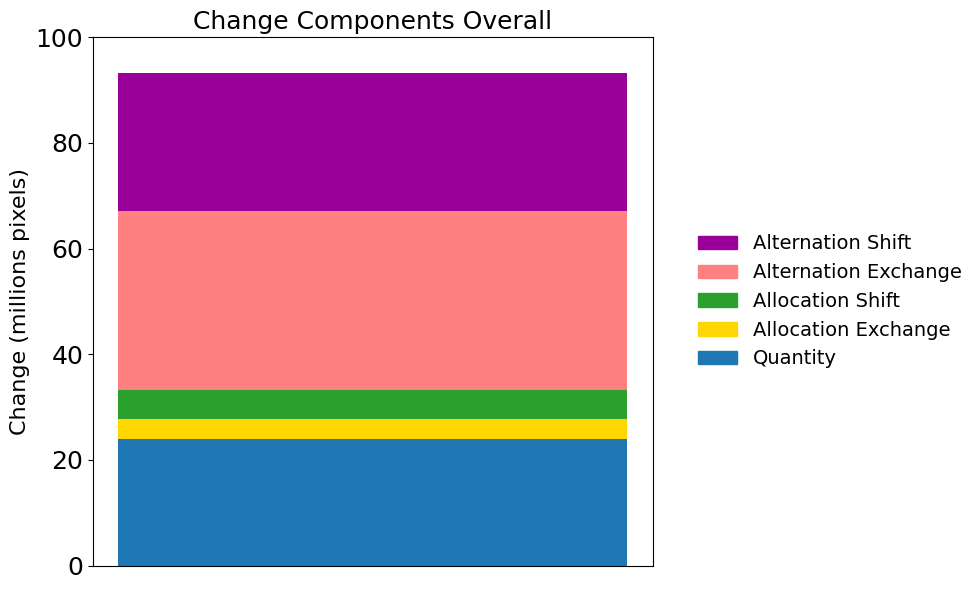

In [29]:
def plot_components_with_alternation(
    csv_path: str,
    output_path: str,
) -> None:
    """
    Stacked bar: Quantity (extent), Allocation Exchange/Shift, Alternation Exchange/Shift.
    """
    # Load data
    df = pd.read_csv(
        csv_path,
    )

    # Colors and component order
    components_color = {
        "Quantity": "#1f77b4",
        "Allocation_Exchange": "#ffd700",
        "Alternation_Exchange": "#ff8080",
        "Allocation_Shift": "#2ca02c",
        "Alternation_Shift": "#990099",
    }
    component_order = [
        "Quantity",
        "Allocation_Exchange",
        "Allocation_Shift",
        "Alternation_Exchange",
        "Alternation_Shift",
    ]

    # Totals per component (extent + alternation)
    component_totals = {
        "Quantity": df[
            (df["Component"] == "Quantity")
            & (df["Time_Interval"] == "extent")
        ]["Gain"].sum(),
        "Allocation_Exchange": df[
            (df["Component"] == "Allocation_Exchange")
            & (df["Time_Interval"] == "extent")
        ]["Gain"].sum(),
        "Allocation_Shift": df[
            (df["Component"] == "Allocation_Shift")
            & (df["Time_Interval"] == "extent")
        ]["Gain"].sum(),
        "Alternation_Exchange": df[
            df["Component"] == "Alternation_Exchange"
        ]["Gain"].sum(),
        "Alternation_Shift": df[
            df["Component"] == "Alternation_Shift"
        ]["Gain"].sum(),
    }

    # Print totals (million pixels)
    print("\nComponent Totals (million pixels):")
    for comp, val in component_totals.items():
        print(f"{comp.replace('_', ' ')}: {val / 1_000_000:.2f} M")

    # Figure
    fig, ax = plt.subplots(
        figsize=(10, 6),
    )

    # Stacked bar (single x=0)
    bottom = 0
    bars = []
    labels = []
    for component in component_order:
        value = component_totals.get(component, 0)
        bar = ax.bar(
            x=0,
            height=value,
            bottom=bottom,
            color=components_color[component],
            edgecolor="none",
            width=1,
        )
        bars.append(bar[0])
        labels.append(component.replace("_", " "))
        bottom += value

    # Axes formatting
    ax.set_ylabel(
        "Change (millions pixels)",
        fontsize=16,
    )
    ax.set_title(
        "Change Components Overall",
        fontsize=18,
    )
    ax.xaxis.set_visible(False)
    ax.tick_params(
        axis="both",
        which="major",
        labelsize=18,
    )

    # Y-axis in millions
    def millions_formatter(x, pos):
        return f"{x / 1_000_000:.0f}"

    ax.set_ylim(
        0,
        100_000_000,
    )
    ax.yaxis.set_major_locator(
        ticker.MultipleLocator(20_000_000)
    )
    ax.yaxis.set_major_formatter(
        ticker.FuncFormatter(millions_formatter)
    )

    # Borders
    for spine in ["top", "right", "left", "bottom"]:
        ax.spines[spine].set_visible(True)

    # Legend (custom labels)
    legend_elements = [
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color=components_color["Alternation_Shift"],
            label="Alternation Shift",
        ),
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color=components_color["Alternation_Exchange"],
            label="Alternation Exchange",
        ),
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color=components_color["Allocation_Shift"],
            label="Allocation Shift",
        ),
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color=components_color["Allocation_Exchange"],
            label="Allocation Exchange",
        ),
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color=components_color["Quantity"],
            label="Quantity",
        ),
    ]
    ax.legend(
        handles=legend_elements,
        loc="center left",
        bbox_to_anchor=(1.05, 0.5),
        fontsize=14,
        frameon=False,
    )

    # Save
    plt.tight_layout()
    plt.savefig(
        os.path.join(
            output_path,
            "graphic_change_components_overall.jpeg",
        ),
        bbox_inches="tight",
        format="jpeg",
        dpi=300,
    )
    plt.show()


if __name__ == "__main__":
    csv_file = os.path.join(
        output_path,
        "change_components.csv",
    )
    plot_components_with_alternation(
        csv_file,
        output_path,
    )


### **5.4 Change Componentes by Class**

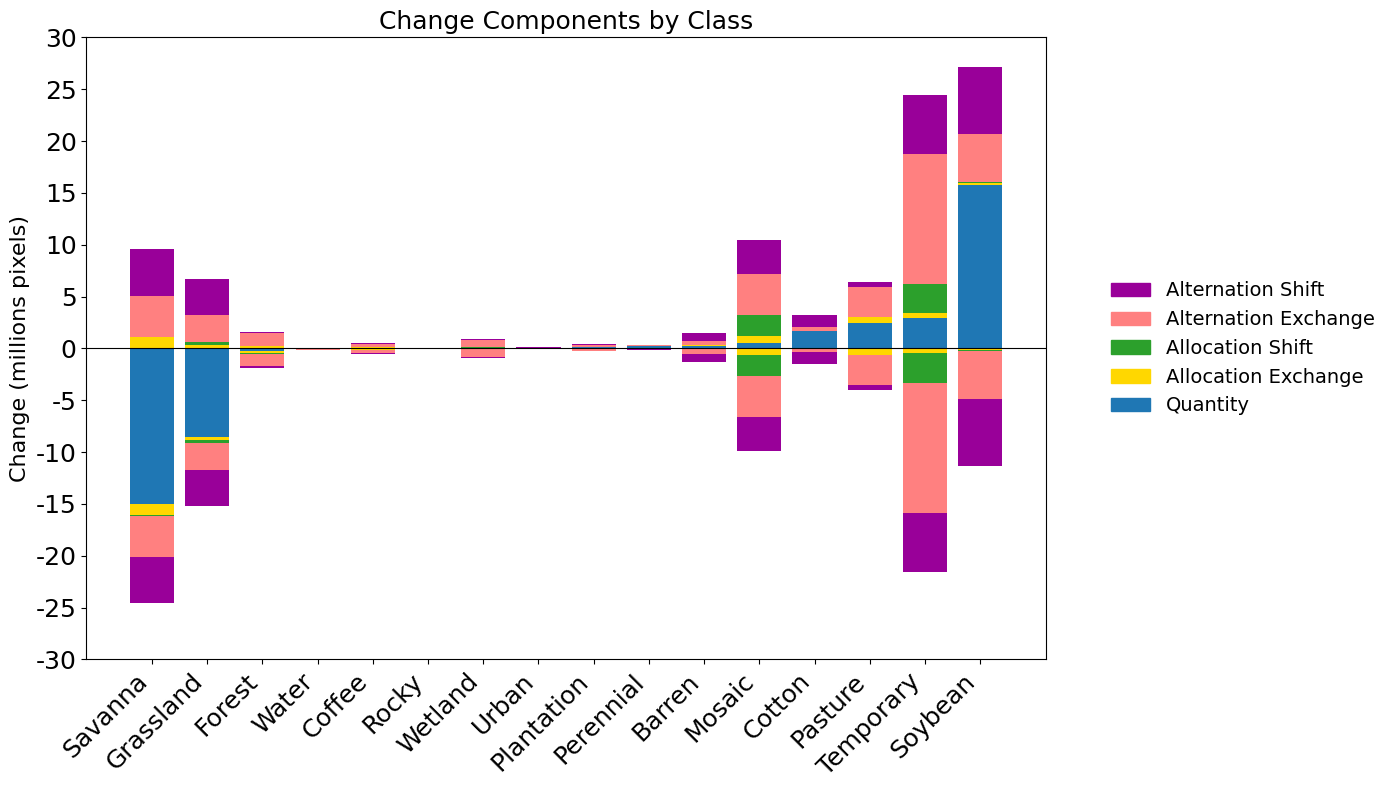

In [30]:
class ComponentVisualizer:
    """Visualize components including alternation."""

    @staticmethod
    def plot_gain_loss_stacked(
        class_labels_dict: dict,
        title: str,
        output_path: str,
    ) -> None:
        """Plot gains and losses with alternation components."""
        # Globals used as in original code
        global df, components_color, component_order
        global figsize, title_fontsize, label_fontsize, tick_labelsize, legend_fontsize

        # Filter data
        filtered_df = df[
            df["Time_Interval"].isin(["extent", "alternation"])
        ]

        # Existing classes (exclude id 0)
        existing_classes = [
            cls for cls in filtered_df["Class"].unique() if cls != 0
        ]

        # Colors and component order (kept local as in original)
        components_color = {
            "Quantity": "#1f77b4",
            "Allocation_Exchange": "#ffd700",
            "Alternation_Exchange": "#ff8080",
            "Allocation_Shift": "#2ca02c",
            "Alternation_Shift": "#990099",
        }
        component_order = [
            "Quantity",
            "Allocation_Exchange",
            "Allocation_Shift",
            "Alternation_Exchange",
            "Alternation_Shift",
        ]

        # Sort classes by net quantity (gain - loss)
        class_totals = []
        for cls in existing_classes:
            class_data = filtered_df[
                filtered_df["Class"] == cls
            ]
            quantity_gain = class_data[
                class_data["Component"] == "Quantity"
            ]["Gain"].sum()
            quantity_loss = class_data[
                class_data["Component"] == "Quantity"
            ]["Loss"].sum()
            class_totals.append((cls, quantity_gain - quantity_loss))

        sorted_classes = sorted(
            class_totals,
            key=lambda x: x[1],
        )
        ordered_classes = [cls for cls, _ in sorted_classes]

        # Figure
        fig, ax = plt.subplots(
            figsize=(14, 8),
        )
        fig.subplots_adjust(
            left=0.1,
            right=0.75,
        )

        x_positions = np.arange(
            len(ordered_classes),
        )
        width = 0.8

        # Stacked bars per class (gains positive, losses negative)
        for idx, cls in enumerate(ordered_classes):
            class_data = filtered_df[
                filtered_df["Class"] == cls
            ]
            gain_bottom = 0
            loss_bottom = 0

            for comp in [
                "Quantity",
                "Allocation_Exchange",
                "Allocation_Shift",
                "Alternation_Exchange",
                "Alternation_Shift",
            ]:
                # Gains
                gains = class_data[
                    class_data["Component"] == comp
                ]["Gain"].sum()
                ax.bar(
                    x_positions[idx],
                    gains,
                    width,
                    bottom=gain_bottom,
                    color=components_color[comp],
                    edgecolor="none",
                )
                gain_bottom += gains

                # Losses (negative)
                losses = -class_data[
                    class_data["Component"] == comp
                ]["Loss"].sum()
                ax.bar(
                    x_positions[idx],
                    losses,
                    width,
                    bottom=loss_bottom,
                    color=components_color[comp],
                    edgecolor="none",
                )
                loss_bottom += losses

        # Axes formatting
        class_names = [
            class_labels_dict.get(cls, {}).get("name", f"{cls}")
            for cls in ordered_classes
        ]
        ax.set_xticks(
            x_positions,
        )
        ax.set_xticklabels(
            class_names,
            rotation=45,
            ha="right",
            fontsize=18,
        )
        ax.axhline(
            0,
            color="black",
            linewidth=0.8,
        )
        ax.set_ylabel(
            "Change (millions pixels)",
            fontsize=16,
        )
        ax.set_title(
            title,
            fontsize=18,
        )
        ax.tick_params(
            axis="both",
            which="major",
            labelsize=18,
        )
        ax.yaxis.set_major_locator(
            ticker.MaxNLocator(integer=True)
        )

        # Y-axis in millions
        def millions_formatter(x, pos):
            return f"{x / 1_000_000:.0f}"

        ax.set_ylim(
            -30_000_000,
            30_000_000,
        )
        ax.yaxis.set_major_locator(
            ticker.MultipleLocator(5_000_000)
        )
        ax.yaxis.set_major_formatter(
            ticker.FuncFormatter(millions_formatter)
        )

        # Legend
        legend_elements = [
            plt.Rectangle(
                (0, 0),
                1,
                1,
                color=components_color["Alternation_Shift"],
                label="Alternation Shift",
            ),
            plt.Rectangle(
                (0, 0),
                1,
                1,
                color=components_color["Alternation_Exchange"],
                label="Alternation Exchange",
            ),
            plt.Rectangle(
                (0, 0),
                1,
                1,
                color=components_color["Allocation_Shift"],
                label="Allocation Shift",
            ),
            plt.Rectangle(
                (0, 0),
                1,
                1,
                color=components_color["Allocation_Exchange"],
                label="Allocation Exchange",
            ),
            plt.Rectangle(
                (0, 0),
                1,
                1,
                color=components_color["Quantity"],
                label="Quantity",
            ),
        ]
        ax.legend(
            handles=legend_elements,
            loc="center left",
            bbox_to_anchor=(1.05, 0.5),
            fontsize=14,
            frameon=False,
        )

        # Save and show
        plt.tight_layout()
        plt.savefig(
            os.path.join(
                output_path,
                "graphic_change_component_change_class.jpeg",
            ),
            format="jpeg",
            dpi=300,
            bbox_inches="tight",
        )
        plt.show()


# Call
ComponentVisualizer.plot_gain_loss_stacked(
    class_labels_dict,
    "Change Components by Class",
    output_path,
)

## **6. Number of Changes**

#### 6.1 Calculate Number of Changes

In [22]:
# Memory-efficient change count (vectorized + chunked)
import logging

# Logger (simple config)
logger = logging.getLogger("change_count")
if not logger.handlers:
    logging.basicConfig(level=logging.INFO)

# Params (configurable)
CHUNK_SIZE = 512          # rows per chunk
NODATA = 255              # nodata for output
BLOCK_SIZE = 256          # tiled block size

logger.info("Starting memory-efficient calculation of number of changes...")

# Output path
output_raster_path = os.path.join(
    output_path,
    "number_of_changes.tif",
)

# Template metadata
with rasterio.open(masked_image_paths[0]) as src:
    meta = src.meta.copy()
    height, width = src.shape

# Output metadata (tiled GeoTIFF)
meta.update(
    {
        "dtype": "uint8",
        "count": 1,
        "nodata": NODATA,
        "compress": "lzw",
        "tiled": True,
        "blockxsize": BLOCK_SIZE,
        "blockysize": BLOCK_SIZE,
    }
)

# Create output and process in chunks
with rasterio.open(
    output_raster_path,
    "w",
    **meta,
) as dst:
    logger.info(f"Output raster: {output_raster_path}")

    # Progress over chunks
    n_chunks = (height + CHUNK_SIZE - 1) // CHUNK_SIZE
    for y_start in tqdm(
        range(0, height, CHUNK_SIZE),
        total=n_chunks,
        desc="Chunks",
        unit="chunk",
    ):
        y_end = min(y_start + CHUNK_SIZE, height)
        chunk_h = y_end - y_start
        window = rasterio.windows.Window(0, y_start, width, chunk_h)

        # Read current chunk from each year
        chunk_stack = np.zeros(
            (len(masked_image_paths), chunk_h, width),
            dtype=np.uint8,
        )
        for i, path in enumerate(masked_image_paths):
            with rasterio.open(path) as src:
                chunk_stack[i] = src.read(
                    1,
                    window=window,
                )

        # Vectorized change count between consecutive rasters
        # Ignore transitions when previous state is background (0)
        transitions = (chunk_stack[1:] != chunk_stack[:-1]) & (chunk_stack[:-1] != 0)
        number_of_changes_chunk = np.sum(
            transitions,
            axis=0,
            dtype=np.uint8,
        )

        # Combined background mask (background in all dates)
        background_mask = np.all(
            chunk_stack == 0,
            axis=0,
        )
        number_of_changes_chunk[background_mask] = NODATA

        # Write chunk
        dst.write(
            number_of_changes_chunk,
            1,
            window=window,
        )

logger.info("Calculation complete. Raster saved.")

Chunks: 100%|██████████| 40/40 [00:15<00:00,  2.54chunk/s]


#### 6.2 Plot Number of Changes Map

Generating map from 'number_of_changes.tif'...


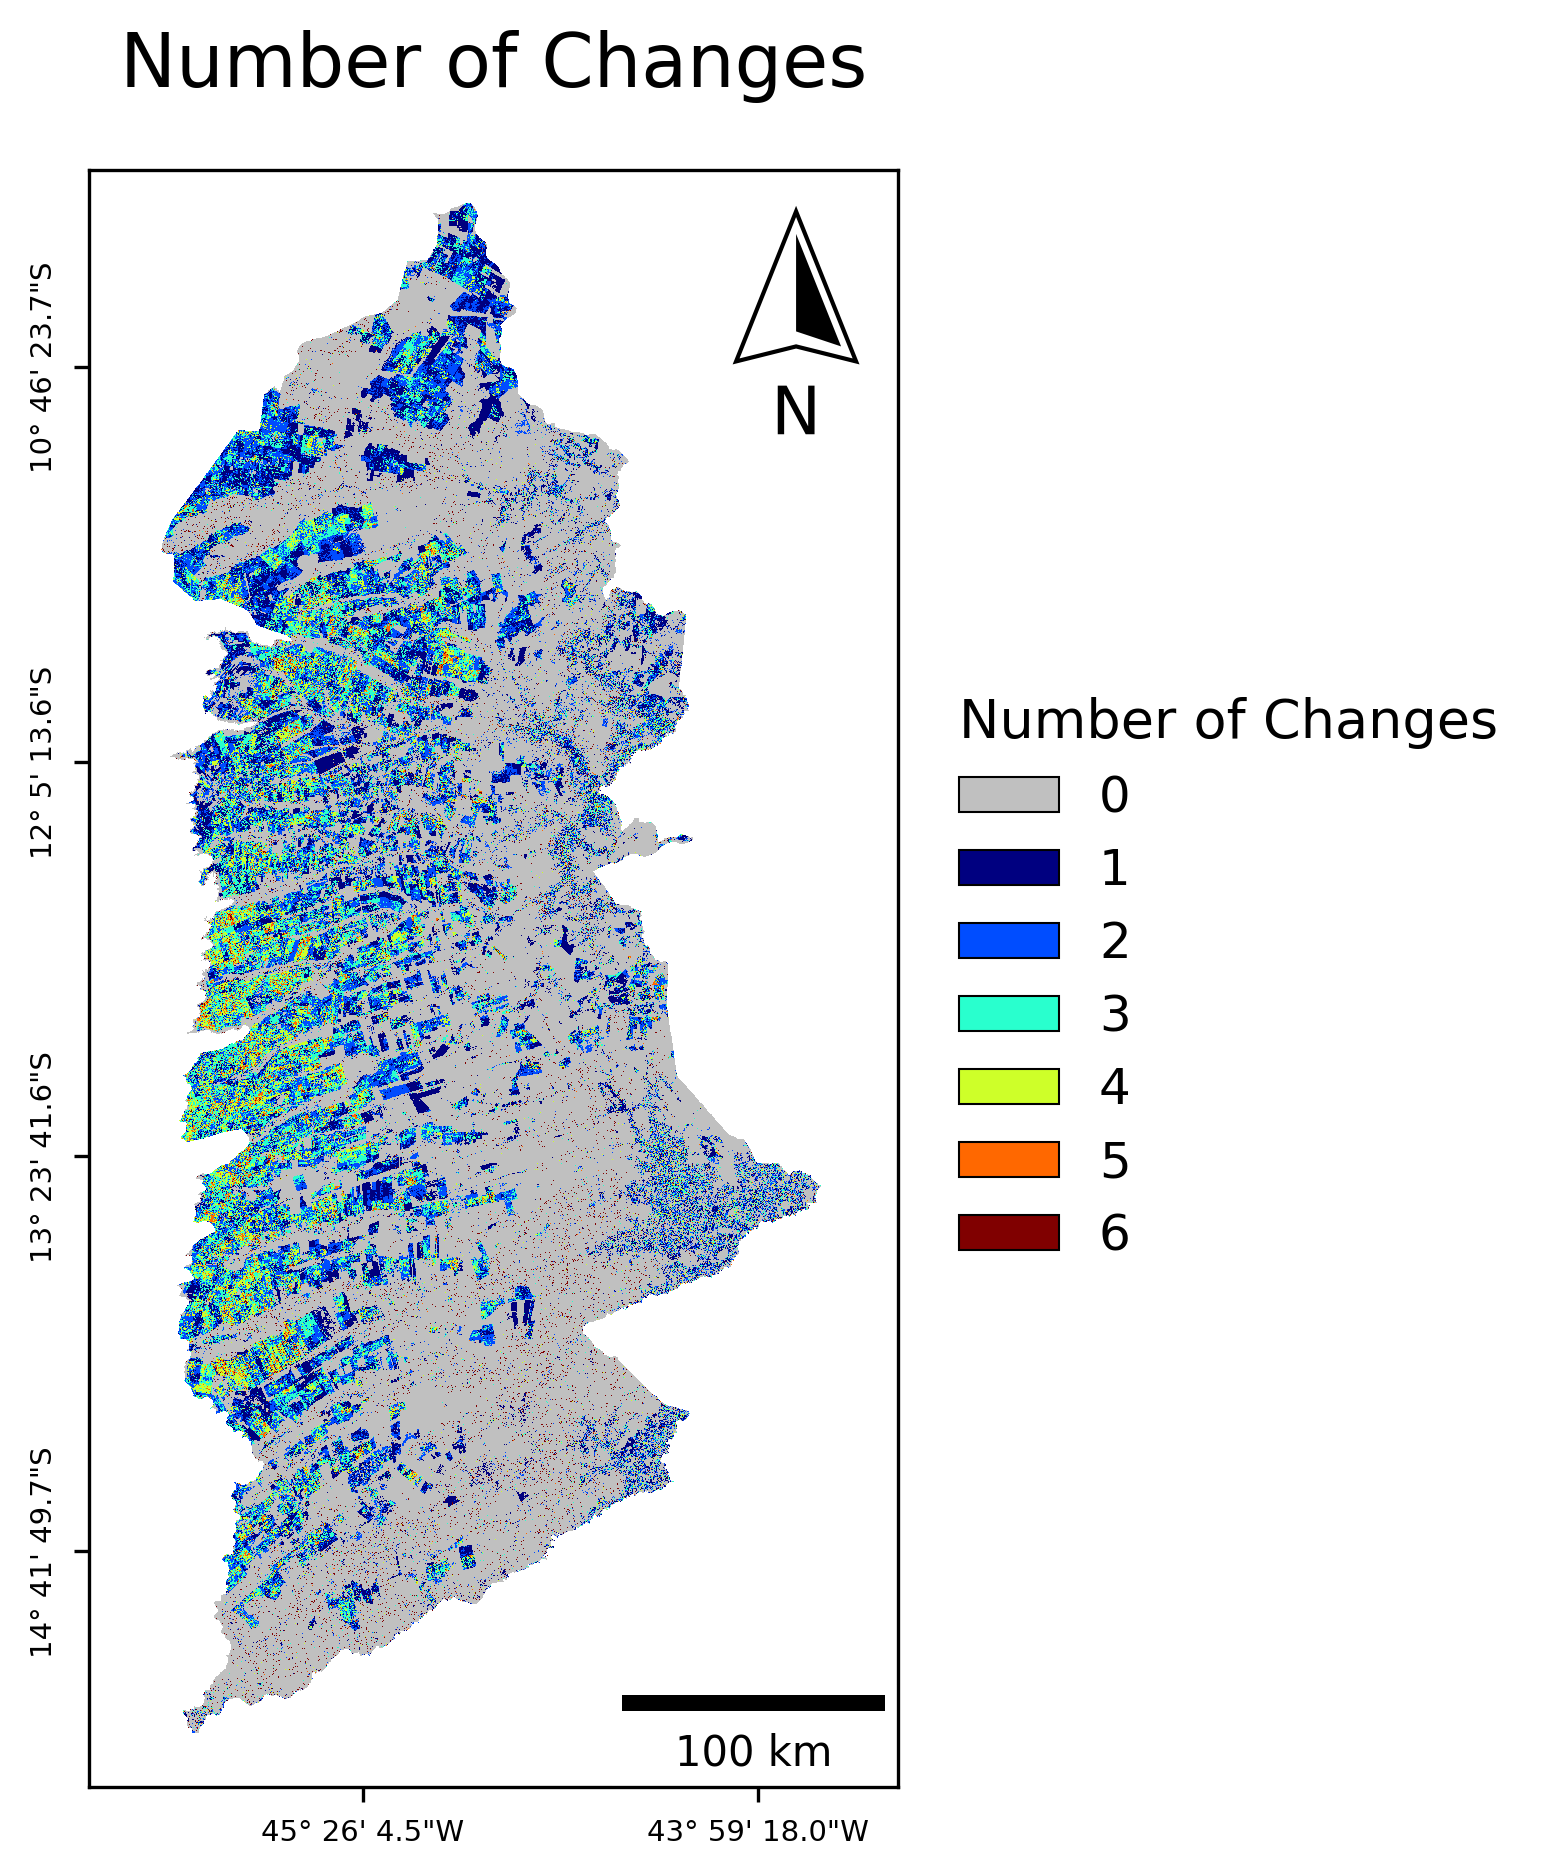


Map figure saved successfully to: /content/drive/MyDrive/change-components/output_colab/map_number_of_changes.png


In [23]:
# Plot "Number of Changes" map with DMS ticks and box legend

print("Generating map from 'number_of_changes.tif'...")

# 1) Input raster path
raster_to_plot_path = os.path.join(
    output_path,
    "number_of_changes.tif",
)

# 2) Read raster and basic metadata
with rasterio.open(raster_to_plot_path) as src:
    scale_factor = 0.15

    data = src.read(
        1,
        out_shape=(
            int(src.height * scale_factor),
            int(src.width * scale_factor),
        ),
        resampling=rasterio.enums.Resampling.nearest,
    )

    nodata_value = src.nodata
    if nodata_value is not None:
        data = np.ma.masked_equal(
            data,
            nodata_value,
        )

    left, bottom, right, top = src.bounds
    src_crs = src.crs.to_string()

# 3) Tick formatters (DMS)
transformer = Transformer.from_crs(
    src_crs,
    "EPSG:4326",
    always_xy=True,
)

def format_x_ticks(x, pos):
    lon, _ = transformer.transform(x, bottom)
    deg = int(abs(lon))
    minutes = int((abs(lon) - deg) * 60)
    seconds = ((abs(lon) - deg) * 60 - minutes) * 60
    hemi = "E" if lon >= 0 else "W"
    return f"{deg}° {minutes}' {seconds:.1f}\"{hemi}"

def format_y_ticks(y, pos):
    _, lat = transformer.transform(left, y)
    deg = int(abs(lat))
    minutes = int((abs(lat) - deg) * 60)
    seconds = ((abs(lat) - deg) * 60 - minutes) * 60
    hemi = "N" if lat >= 0 else "S"
    return f"{deg}° {minutes}' {seconds:.1f}\"{hemi}"

# 4) Figure
fig, ax = plt.subplots(
    figsize=(10, 7),
    dpi=300,
)

# Data range
min_val = int(np.ma.min(data))
max_val = int(np.ma.max(data))

# 5) Colormap (gray for 0 + jet for 1..max)
original_cmap = plt.get_cmap(
    "jet",
)
color_list = ["#c0c0c0"] + [
    original_cmap(i) for i in np.linspace(0, 1, max_val)
]
cmap = ListedColormap(
    color_list,
)

# Discrete normalization
bounds = np.arange(
    min_val,
    max_val + 2,
) - 0.5
norm = BoundaryNorm(
    bounds,
    cmap.N,
)

# 6) Plot raster
ax.imshow(
    data,
    extent=[left, right, bottom, top],
    cmap=cmap,
    interpolation="none",
    norm=norm,
)

# 7) Discrete box legend
legend_elements = []
for i in range(min_val, max_val + 1):
    legend_elements.append(
        Patch(
            facecolor=cmap(norm(i)),
            edgecolor="black",
            linewidth=0.5,
            label=str(i),
        )
    )

ax.legend(
    handles=legend_elements,
    title="Number of Changes",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    fontsize=12,
    title_fontsize=13,
    alignment="left",
)

# 8) Cartographic elements
scalebar = ScaleBar(
    1 / 1000,
    units="km",
    length_fraction=0.4,
    location="lower right",
    scale_formatter=lambda value, _: f"{int(value)} km",
)
ax.add_artist(
    scalebar,
)

north_arrow(
    ax,
    location="upper right",
    shadow=False,
    rotation={"degrees": 0},
)

# 9) Axes styling
ax.set_title(
    "Number of Changes",
    fontsize=18,
    pad=20,
)
ax.set_aspect(
    "equal",
)
ax.xaxis.set_major_formatter(
    FuncFormatter(format_x_ticks)
)
ax.yaxis.set_major_formatter(
    FuncFormatter(format_y_ticks)
)
ax.tick_params(
    axis="x",
    which="major",
    labelsize=7,
    pad=4,
)
ax.tick_params(
    axis="y",
    which="major",
    labelsize=7,
    pad=4,
)
ax.xaxis.set_major_locator(
    plt.MaxNLocator(3)
)
ax.yaxis.set_major_locator(
    plt.MaxNLocator(6)
)
plt.setp(
    ax.get_yticklabels(),
    rotation=90,
    va="center",
)

# 10) Save
output_figure_path = os.path.join(
    output_path,
    "map_number_of_changes.png",
)
plt.savefig(
    output_figure_path,
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.5,
)
plt.show()

print(
    f"\nMap figure saved successfully to: {output_figure_path}"
)

## **7. Trajectory Classification**


---
### Overview
This section provides a framework for processing and classifying pixel trajectories in raster datasets.


### 7.1 Caclulate Trajectory Analysis

This section processes and visualizes raster data by scaling, applying a color map, and adding graphical elements like legends, scale bars, and north arrows. The output is a high-resolution image of the classified raster data.

In [31]:
# Trajectory classification

@nb.njit(nogil=True)
def classify_pixel(pixel_series):
    """Classify a pixel trajectory."""
    if pixel_series[0] == 0:
        return 0

    start = pixel_series[0]
    end = pixel_series[-1]

    has_variation = False
    direct_transition = False

    # Single pass over the series
    for i in range(len(pixel_series) - 1):
        current = pixel_series[i]
        next_val = pixel_series[i + 1]

        if not has_variation and current != next_val:
            has_variation = True

        if not direct_transition and current == start and next_val == end:
            direct_transition = True

    # 1) No change
    if not has_variation:
        return 1
    # 2) Changed but ended where started
    if start == end:
        return 2
    # 3) Direct transition start→end
    if direct_transition:
        return 3
    # 4) Other patterns
    return 4


@nb.njit(nogil=True, parallel=True)
def process_stack_parallel(stack, height, width):
    """Classify all pixels in parallel."""
    result = np.zeros((height, width), dtype=np.uint8)
    for y in prange(height):
        for x in range(width):
            result[y, x] = classify_pixel(stack[:, y, x])
    return result


class TrajectoryAnalyzer:
    @staticmethod
    def process_rasters(
        output_path,
        suffix="_masked.tif",
        chunk_size=500,
    ):
        """Process rasters in chunks and write 'trajectory.tif'."""
        os.makedirs(output_path, exist_ok=True)
        if not os.path.isdir(output_path):
            raise ValueError(f"Path must be a directory: {output_path}")

        raster_files = sorted(
            os.path.join(output_path, f)
            for f in os.listdir(output_path)
            if f.endswith(suffix)
        )
        if not raster_files:
            raise ValueError(f"No files found with suffix '{suffix}'")

        # Read shape and metadata from the first raster
        with rasterio.open(raster_files[0]) as src:
            meta = src.meta
            height, width = src.shape

        result = np.zeros((height, width), dtype=np.uint8)
        print(f"Starting processing of {height} rows in chunks of {chunk_size}...")

        # Row-wise chunking to limit memory
        for y_start in range(0, height, chunk_size):
            y_end = min(y_start + chunk_size, height)
            h = y_end - y_start

            stack = np.zeros((len(raster_files), h, width), dtype=np.uint8)
            for i, fpath in enumerate(raster_files):
                with rasterio.open(fpath) as src:
                    stack[i] = src.read(
                        1,
                        window=((y_start, y_end), (0, width)),
                    )

            result[y_start:y_end] = process_stack_parallel(stack, h, width)
            print(f"  > Processed rows {y_start}–{y_end}")

        # Save output
        meta.update(
            {
                "dtype": "uint8",
                "nodata": 0,
                "count": 1,
                "compress": "lzw",
            }
        )
        out_file = os.path.join(output_path, "trajectory.tif")
        with rasterio.open(out_file, "w", **meta) as dst:
            dst.write(result, 1)

        return out_file


# ── Run ────────────────────────────────────────────────────────────────────────
print("Starting trajectory analysis...")

trajectory_file = TrajectoryAnalyzer.process_rasters(
    output_path,
    suffix="_masked.tif",
    chunk_size=500,
)

print(f"\nProcessing complete! Results saved to: {trajectory_file}")


Starting trajectory analysis...
Starting processing of 20480 rows in chunks of 500...
  > Processed rows 0–500
  > Processed rows 500–1000
  > Processed rows 1000–1500
  > Processed rows 1500–2000
  > Processed rows 2000–2500
  > Processed rows 2500–3000
  > Processed rows 3000–3500
  > Processed rows 3500–4000
  > Processed rows 4000–4500
  > Processed rows 4500–5000
  > Processed rows 5000–5500
  > Processed rows 5500–6000
  > Processed rows 6000–6500
  > Processed rows 6500–7000
  > Processed rows 7000–7500
  > Processed rows 7500–8000
  > Processed rows 8000–8500
  > Processed rows 8500–9000
  > Processed rows 9000–9500
  > Processed rows 9500–10000
  > Processed rows 10000–10500
  > Processed rows 10500–11000
  > Processed rows 11000–11500
  > Processed rows 11500–12000
  > Processed rows 12000–12500
  > Processed rows 12500–13000
  > Processed rows 13000–13500
  > Processed rows 13500–14000
  > Processed rows 14000–14500
  > Processed rows 14500–15000
  > Processed rows 15000–155

### 7.2 Plot Trajectory Analysis Graphic


Trajectory Percentages:
Trajectory 1: 58.01%
Trajectory 2: 5.81%
Trajectory 3: 19.35%
Trajectory 4: 16.82%


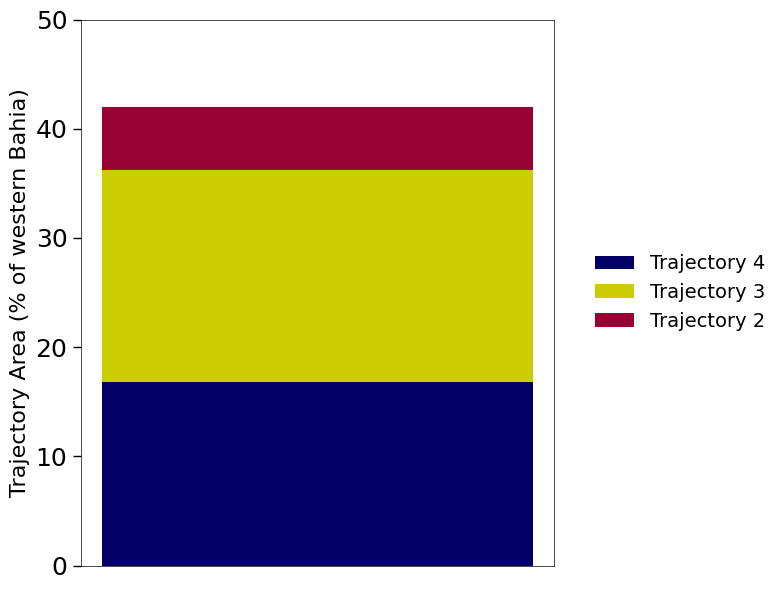

In [32]:
def plot_trajectory_distribution(output_path: str) -> None:
    """
    Plot a stacked bar with the distribution of trajectory classes.
    Reads 'trajectory.tif' from output_path and saves a JPEG.
    """
    # Raster path
    raster_path = os.path.join(
        output_path,
        "trajectory.tif",
    )

    # Read raster
    with rasterio.open(raster_path) as src:
        traj_data = src.read(1)
        nodata = src.nodata

    # Mask NoData and count classes
    masked_traj = np.ma.masked_where(
        traj_data == nodata,
        traj_data,
    )
    unique, counts = np.unique(
        masked_traj.compressed(),
        return_counts=True,
    )
    total_pixels = counts.sum()

    # Percentages
    percentages = {
        k: (v / total_pixels) * 100.0
        for k, v in zip(unique, counts)
    }

    # Print table
    print("\nTrajectory Percentages:")
    for traj, pct in percentages.items():
        print(f"Trajectory {traj}: {pct:.2f}%")

    # Order and colors
    ordered_trajs = [4, 3, 2]
    colors = {
        4: "#000066",  # dark blue
        3: "#cccc00",  # gold
        2: "#990033",  # dark red
    }

    # Y-axis upper bound (nearest 10)
    max_percentage = sum(
        percentages.get(traj, 0.0) for traj in ordered_trajs
    )
    y_max = np.ceil(max_percentage / 10.0) * 10.0

    # Figure
    fig, ax = plt.subplots(
        figsize=(8, 6),
    )

    # Stacked bars (single category at x=0)
    bottom = 0.0
    for traj in ordered_trajs:
        if traj in percentages:
            ax.bar(
                0,
                percentages[traj],
                bottom=bottom,
                color=colors[traj],
                width=0.4,
                edgecolor="none",
            )
            bottom += percentages[traj]

    # Labels
    ax.set_ylabel(
        "Trajectory Area (% of western Bahia)",
        fontsize=16,
    )

    # Frame (all spines visible)
    for spine in ["top", "right", "bottom", "left"]:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color("black")
        ax.spines[spine].set_linewidth(0.5)

    # Ticks
    ax.tick_params(
        axis="y",
        which="minor",
        length=0,
    )
    ax.tick_params(
        axis="y",
        which="major",
        labelsize=18,
        length=6,
        width=1,
    )

    # Y scale
    ax.set_ylim(
        0,
        y_max,
    )
    ax.yaxis.set_major_locator(
        ticker.MultipleLocator(np.floor(y_max / 5.0))
    )

    # Hide x-axis
    ax.xaxis.set_visible(False)

    # No grid
    ax.grid(False)

    # Legend
    legend_elements = [
        Patch(facecolor=colors[4], label="Trajectory 4"),
        Patch(facecolor=colors[3], label="Trajectory 3"),
        Patch(facecolor=colors[2], label="Trajectory 2"),
    ]
    ax.legend(
        handles=legend_elements,
        loc="center left",
        bbox_to_anchor=(1.05, 0.5),
        fontsize=14,
        frameon=False,
    )

    # Save
    plt.tight_layout()
    plt.savefig(
        os.path.join(
            output_path,
            "trajectory_distribution.jpeg",
        ),
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()


# Usage
if __name__ == "__main__":
    plot_trajectory_distribution(
        output_path,
    )

### 7.3 Plot Trajectory Analysis Map

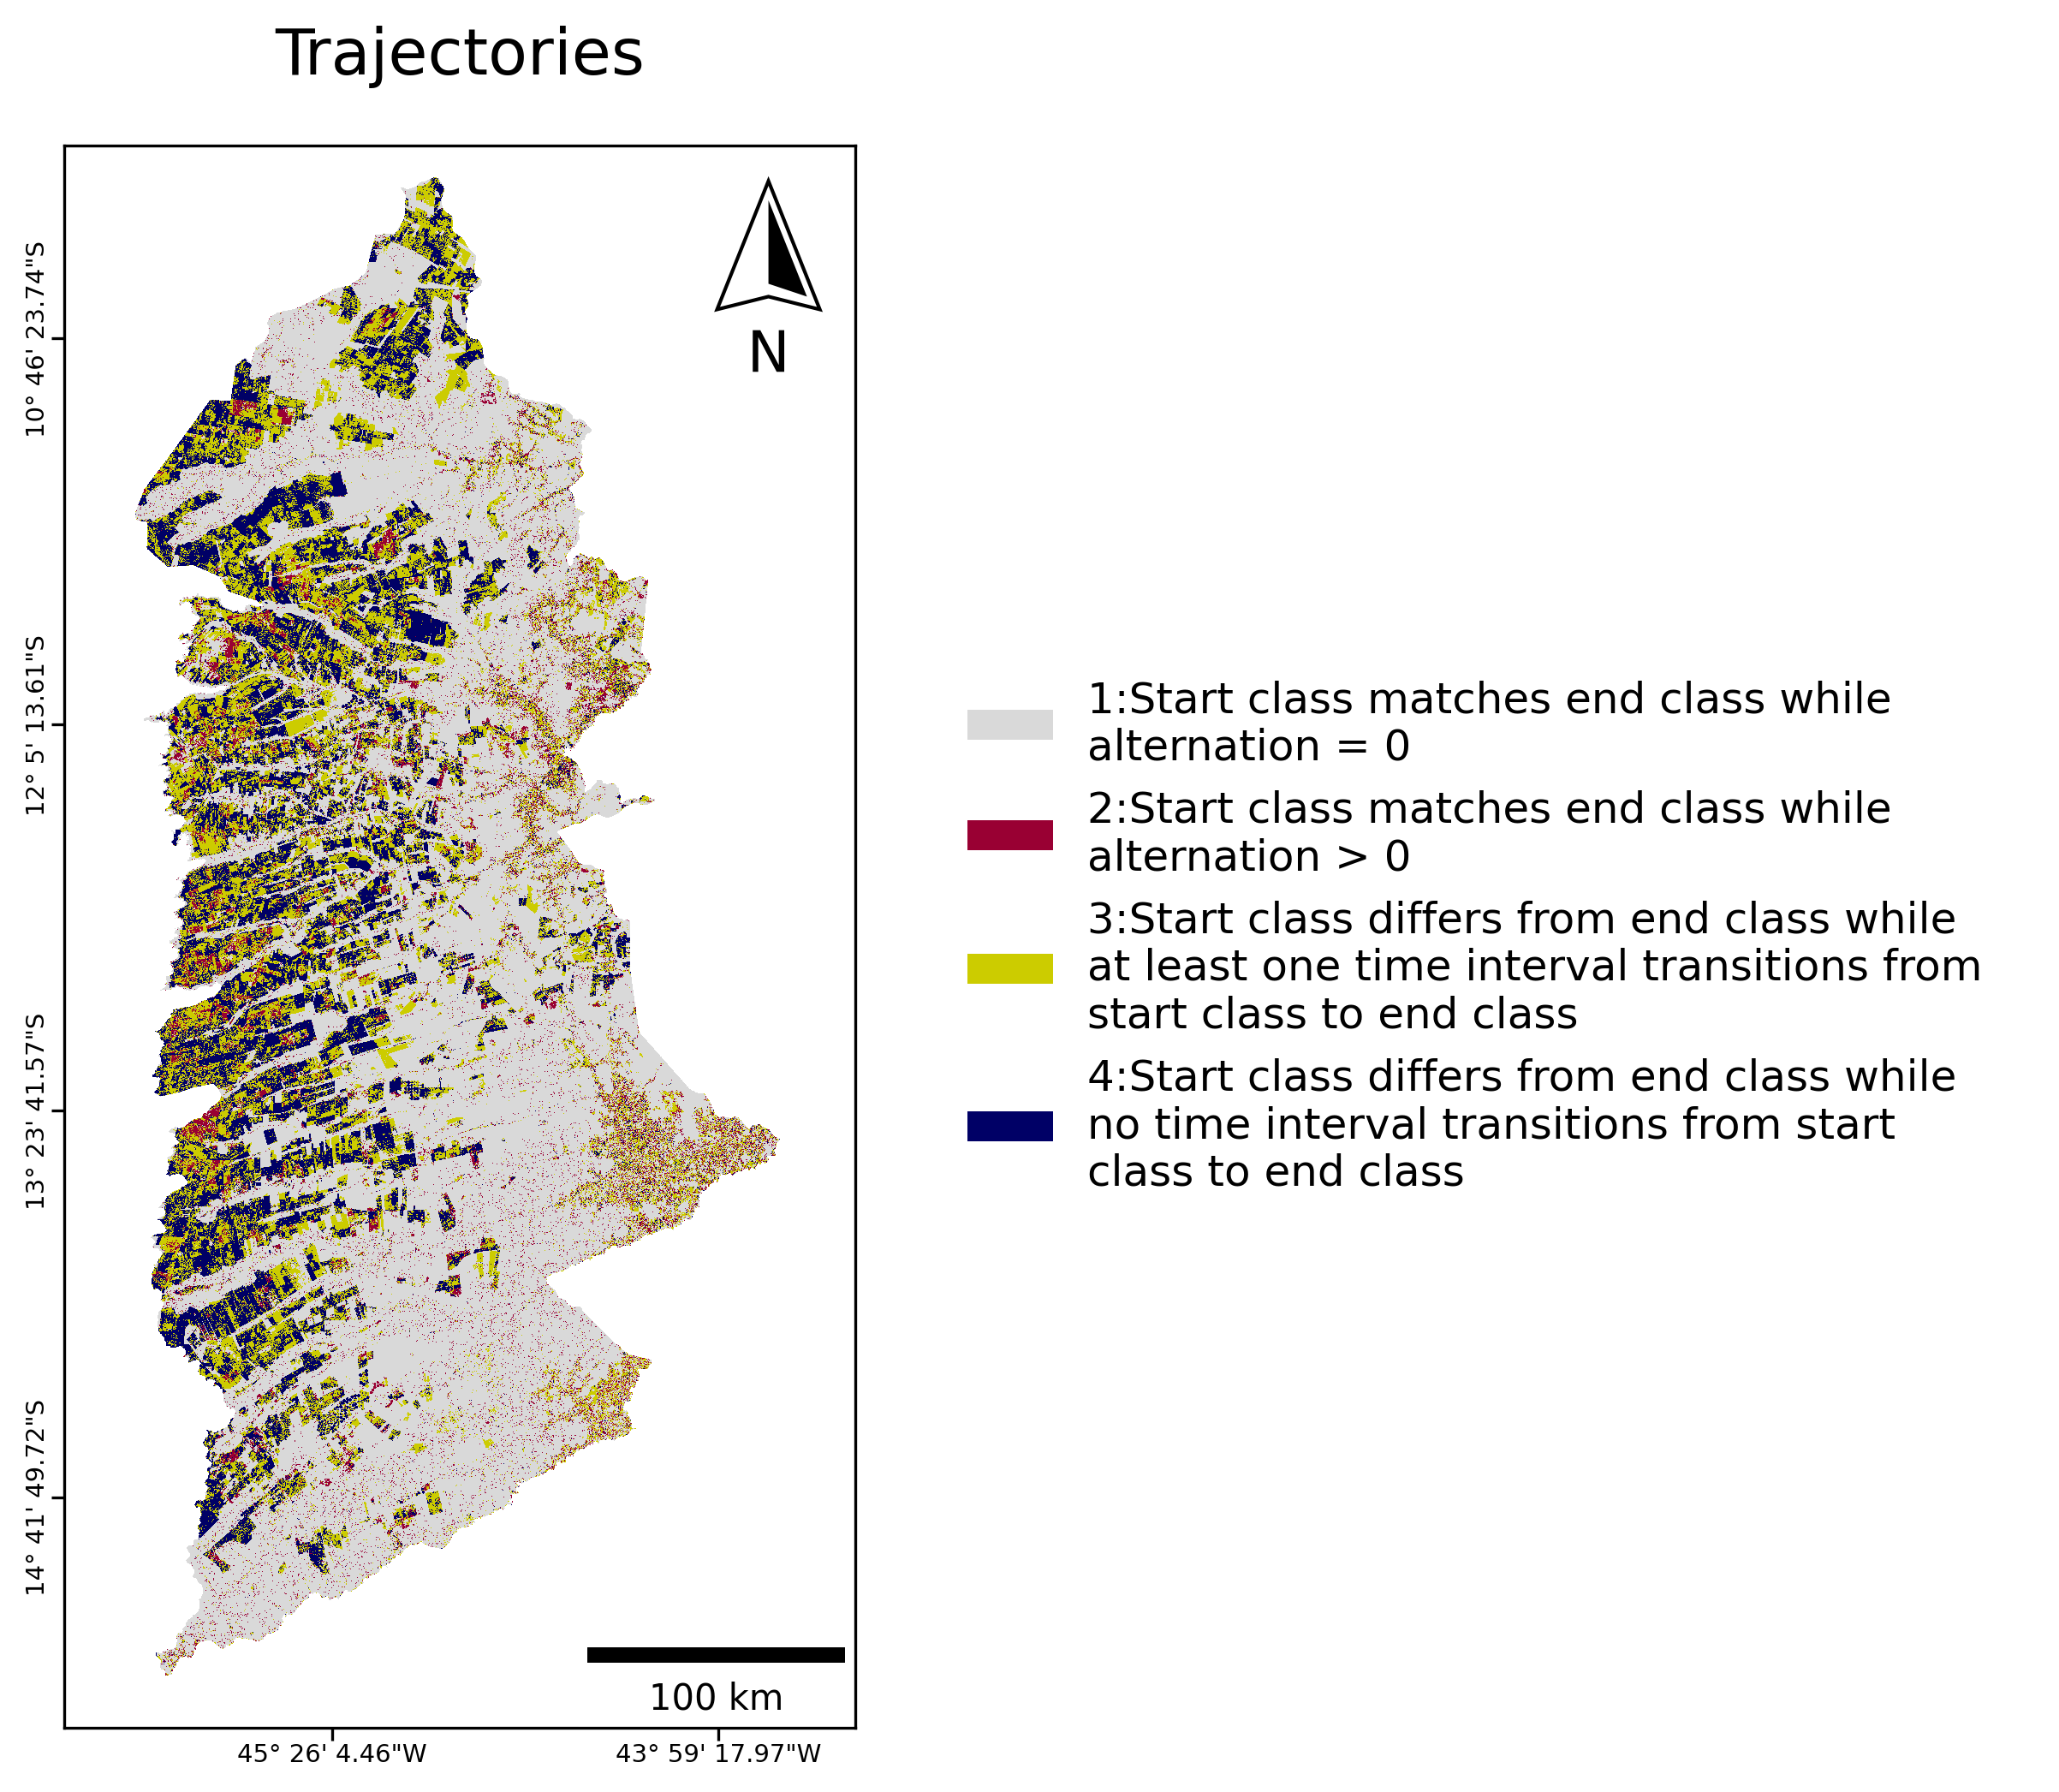

Map saved successfully in the folder: /content/drive/MyDrive/change-components/output_colab


In [33]:
# Plot trajectory map with DMS ticks, legend, north arrow, and scalebar

# Paths and basic params
raster_path = os.path.join(
    output_path,
    "trajectory.tif",
)
dpi = 300
scale_factor = 0.5

# Legend elements
legend_elements = [
    Rectangle(
        (0, 0),
        1,
        1,
        facecolor="#d9d9d9",
        label="1:Start class matches end class while\nalternation = 0",
    ),
    Rectangle(
        (0, 0),
        1,
        1,
        facecolor="#990033",
        label="2:Start class matches end class while\nalternation > 0",
    ),
    Rectangle(
        (0, 0),
        1,
        1,
        facecolor="#cccc00",
        label="3:Start class differs from end class while\nat least one time interval transitions from\nstart class to end class",
    ),
    Rectangle(
        (0, 0),
        1,
        1,
        facecolor="#000066",
        label="4:Start class differs from end class while\nno time interval transitions from start\nclass to end class",
    ),
]

# Colormap
cmap = ListedColormap(
    [
        "#ffffff",
        "#d9d9d9",
        "#990033",
        "#cccc00",
        "#000066",
    ]
)

with rasterio.open(raster_path) as src:
    # Read and downsample (nearest: categorical)
    data = src.read(
        1,
        out_shape=(
            int(src.height * scale_factor),
            int(src.width * scale_factor),
        ),
        resampling=rasterio.enums.Resampling.nearest,
    )

    # Bounds and CRS
    left, bottom, right, top = src.bounds
    src_crs = src.crs.to_string()

# Transformer and tick formatters (DMS)
transformer = Transformer.from_crs(
    src_crs,
    "EPSG:4326",
    always_xy=True,
)

def format_x_ticks(x, pos):
    lon, _ = transformer.transform(x, bottom)
    deg = int(abs(lon))
    minutes = int((abs(lon) - deg) * 60)
    seconds = ((abs(lon) - deg) * 60 - minutes) * 60
    hemi = "E" if lon >= 0 else "W"
    return f"{deg}° {minutes}' {seconds:.2f}\"{hemi}"

def format_y_ticks(y, pos):
    _, lat = transformer.transform(left, y)
    deg = int(abs(lat))
    minutes = int((abs(lat) - deg) * 60)
    seconds = ((abs(lat) - deg) * 60 - minutes) * 60
    hemi = "N" if lat >= 0 else "S"
    return f"{deg}° {minutes}' {seconds:.2f}\"{hemi}"

# Figure
fig, ax = plt.subplots(
    figsize=(14, 8),
    dpi=dpi,
)

# Raster plot
ax.imshow(
    data,
    cmap=cmap,
    extent=[left, right, bottom, top],
    interpolation="none",
)

# Ticks
ax.xaxis.set_major_formatter(
    FuncFormatter(format_x_ticks)
)
ax.yaxis.set_major_formatter(
    FuncFormatter(format_y_ticks)
)

# Scalebar (km)
scalebar = ScaleBar(
    1 / 1000,
    units="km",
    length_fraction=0.4,
    location="lower right",
    scale_formatter=lambda value, _: f"{int(value)} km",
)
ax.add_artist(
    scalebar
)

# North arrow
north_arrow(
    ax,
    location="upper right",
    shadow=False,
    rotation={"degrees": 0},
)

# Style
ax.set_aspect(
    "equal",
)
ax.tick_params(
    axis="x",
    which="major",
    labelsize=7,
    pad=4,
)
ax.tick_params(
    axis="y",
    which="major",
    labelsize=7,
    pad=4,
)
ax.xaxis.set_major_locator(
    plt.MaxNLocator(3)
)
ax.yaxis.set_major_locator(
    plt.MaxNLocator(6)
)
plt.setp(
    ax.get_yticklabels(),
    rotation=90,
    va="center",
)
plt.title(
    "Trajectories",
    fontsize=18,
    pad=20,
)

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_horizontalalignment("center")
    label.set_verticalalignment("center")

# Legend
ax.legend(
    handles=legend_elements,
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    frameon=False,
    fontsize=12,
    borderpad=1.2,
    handletextpad=0.8,
    columnspacing=2,
)

# Save
plt.savefig(
    os.path.join(
        output_path,
        "map_trajectories_degree.jpeg",
    ),
    dpi=dpi,
    bbox_inches="tight",
    pad_inches=0.5,
    pil_kwargs={"optimize": True, "quality": 95},
)
plt.show()
plt.close()

print(
    "Map saved successfully in the folder:",
    output_path,
)